## 0. Libraries & Configurations

EDA 실행에 필요한 library를 설치합니다.

In [42]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [43]:
class cfg:
    data_dir = '/opt/ml/input/data/train'  
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'
    for_labeling = f'{img_dir}/*/'

In [44]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


---

## 1. Data Bias

Data 분포도를 알아보기 위해 각 label별 이미지의 개수를 알아보고, matplotlib을 이용해 시각화했습니다.

In [45]:
wedgeprops = {'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

##### gender

In [46]:
# label별 분포 (gender)

is_female = df['gender'] == 'female'
is_male = df['gender'] == 'male'

female = len(df[is_female])
male = len(df[is_male])

print(f"male data: {male} | female data: {female}")

male data: 1042 | female data: 1658


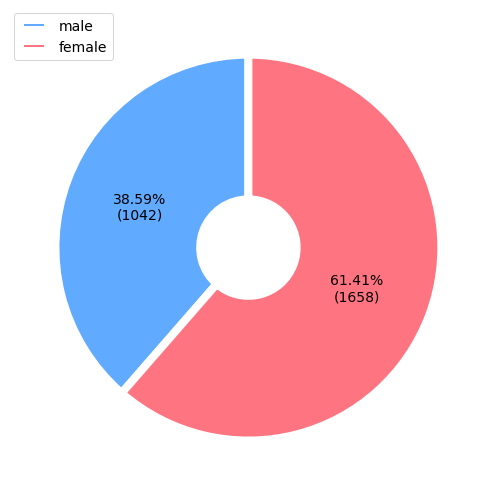

In [47]:
# 원형 그래프로 시각화

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

values = [male, female]
labels = ['male', 'female']
colors = ["#60aaff", "#fe7581"]

ax.pie(values,
            autopct=make_autopct(values),
            textprops={'fontsize': 14},
            startangle=90, colors = colors,
            wedgeprops=wedgeprops)
ax.legend(labels, fontsize= 14, loc = 'upper left')

plt.tight_layout()
plt.show()

##### age

In [48]:
# label별 분포 (age)

is_under_30 = df['age'] < 30
is_between = df['age'] < 60
is_over_60 = df['age'] >= 60

under_30 = len(df[is_under_30])
between = len(df[is_between]) - under_30
over_60 = len(df[is_over_60])

print(f"under 30: {under_30} | 30~59: {between} | over 60: {over_60}")

under 30: 1281 | 30~59: 1227 | over 60: 192


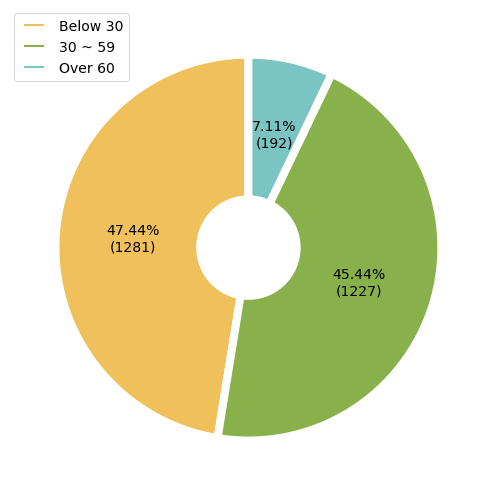

In [61]:
# 원형 그래프로 시각화

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

values_ = [under_30, between, over_60]
labels_ = ['Below 30', '30 ~ 59', 'Over 60']
colors_ = ["#F0C05A", "#88B04B", "#7BC4C4"]

wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}
ax.pie(values_,
        autopct=make_autopct(values_),
        textprops={'fontsize': 14},
        startangle=90, colors = colors_,
        wedgeprops=wedgeprops)
ax.legend(labels_, fontsize=14, loc = 'upper left')

plt.tight_layout()
plt.show()

##### gender & age

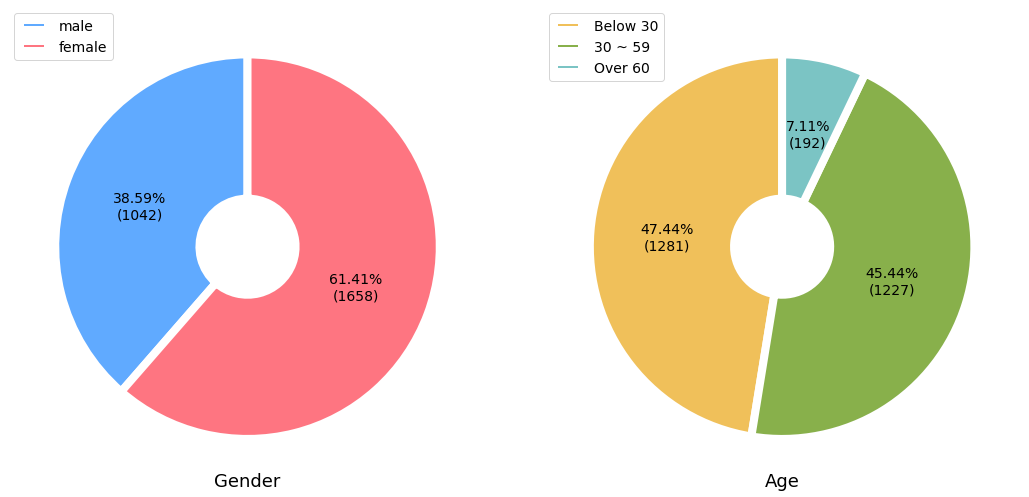

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 8}

axes[0].set_title("Gender", fontsize = 18, y = -0.01)
axes[0].pie(values,
            autopct=make_autopct(values),
            textprops={'fontsize': 14},
            startangle=90, colors = colors,
            wedgeprops=wedgeprops)
axes[0].legend(labels, fontsize= 14, loc = 'upper left')

axes[1].set_title("Age", fontsize = 18, y = -0.01)
axes[1].pie(values_,
            autopct=make_autopct(values_),
            textprops={'fontsize': 14},
            startangle=90, colors = colors_,
            wedgeprops=wedgeprops)
axes[1].legend(labels_, fontsize=14, loc = 'upper left')

plt.tight_layout()
plt.show()

> female data의 양이 male data 보다 약 두배 가까이 많고, 60대 이상의 data 양이 적은 것을 확인했다.

In [51]:
# gender와 age의 상관관계

Female_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }
Male_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }

for idx in range(len(df)) :
    person = df.iloc[idx]
    if person['gender'] == 'female' :
        if person['age'] <= 20 : Female_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Female_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Female_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Female_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Female_Age["50~59"] += 1
        elif 60 <= person['age'] : Female_Age["60~"] += 1
    elif person['gender'] == 'male' :
        if person['age'] <= 20 : Male_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Male_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Male_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Male_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Male_Age["50~59"] += 1
        elif 60 <= person['age'] : Male_Age["60~"] += 1

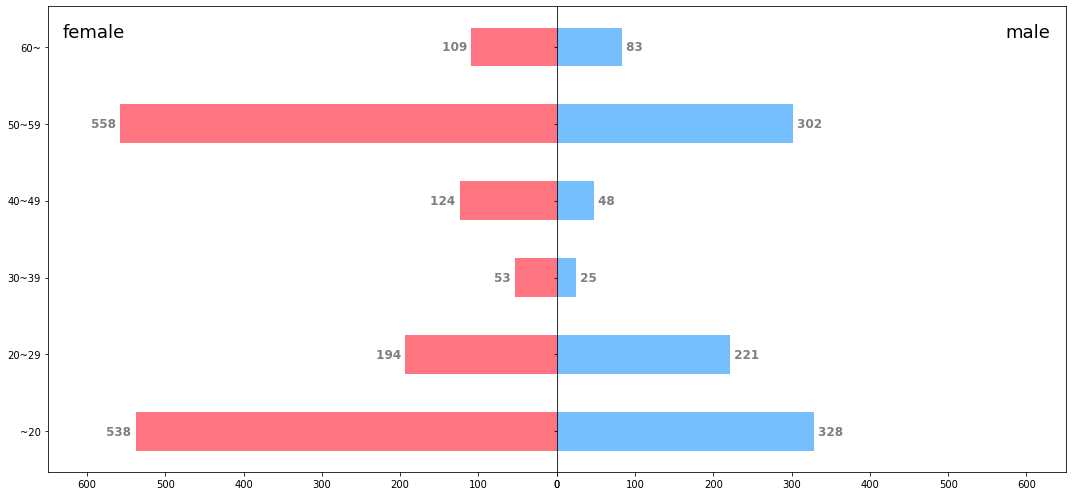

In [73]:
# 가로 그래프로 시각화

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15, 7), gridspec_kw={"wspace":0})

female = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
female_values = list(Female_Age.values())
axes[0].barh(female, female_values, color= "#fe7581", height = 0.5)
axes[0].set_title('female', fontsize=18, loc = 'left', y = 0.92, x = 0.03)

male = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
male_values = list(Male_Age.values())
axes[1].barh(male, male_values, color="#75befe", height = 0.5)
axes[1].set_title('male', fontsize=18, loc = 'right', y = 0.92, x = 0.97)

xmax = 650
axes[0].set_xlim(xmax, 0)
axes[1].set_xlim(0, xmax)

for ax in axes:
    for i, p in enumerate(ax.patches):
        w = p.get_width()
        if ax == axes[0]:
            ha = "right"
        else:
            ha = "left"
        
        ax.text(w, i, f" {format(w, ',')} ", 
                fontsize=12, va="center", ha=ha, 
                fontweight="bold", alpha=0.5)

plt.tight_layout()
plt.show()

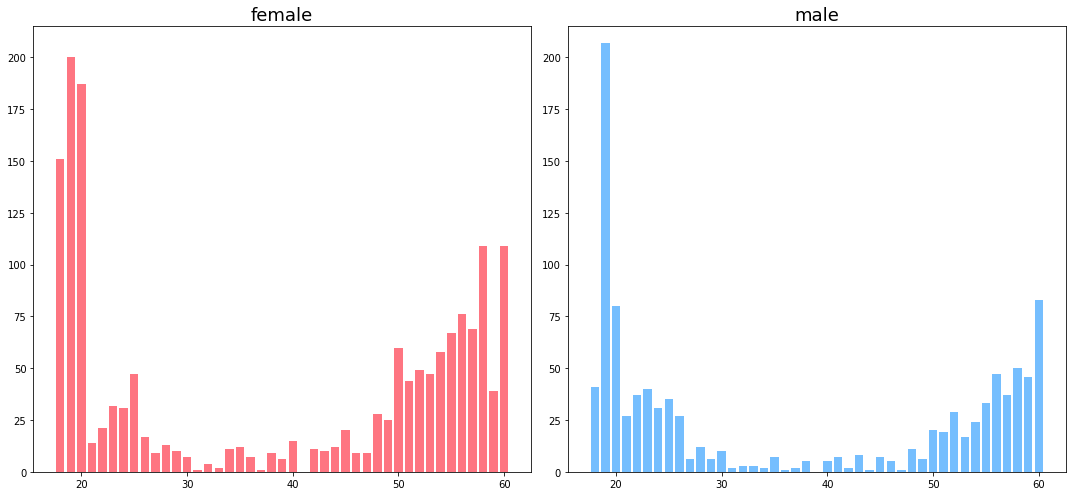

In [83]:
# 세로 그래프로 시각화, 세분화

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

grp = df.groupby('gender')['age'].value_counts()

axes[0].bar(grp['female'].index, grp['female'], color='#fe7581', zorder=5)
axes[0].set_title('female', fontsize=18)

axes[1].bar(grp['male'].index, grp['male'], color='#75befe', zorder=5)
axes[1].set_title('male', fontsize=18)

ymax = 215
axes[0].set_ylim(0, ymax)
axes[1].set_ylim(0, ymax)

plt.tight_layout()
plt.show()

> 성별 별로 나이 분포를 확인해본 결과 남녀 모두 20대 이하, 50세 이상의 구간에 data가 편중되어 있었다.

##### 18개의 label별 Data 분포

In [75]:
def check_mask(path): 
    if 'mask' in path and 'incorrect' not in path: 
        return list(range(0, 6)) # 0~5 중에 하나 
    elif 'incorrect' in path: 
        return list(range(6, 12)) # 6~11 
    else: 
        return list(range(12, 18)) # 12~17 

In [76]:
def check_gender(path): 
    if 'female' in path: 
        return [3, 4, 5, 9, 10, 11, 15, 16, 17]
    else: 
        return [0, 1, 2, 6, 7, 8, 12, 13, 14]

In [77]:
def check_age(path): 
    split_folder = path.split('/')
    name = split_folder[7].split('_')
    age = int(name[3])

    if age < 30: 
        return [0, 3, 6, 9, 12, 15]
    elif 30 <= age < 60: 
        return [1, 4, 6, 10, 13, 16]
    else: 
        return [2, 5, 8, 11, 14, 17]

In [78]:
folders = glob(cfg.for_labeling, recursive=True) 
distribution = [0] * 18

for folder in folders: 
    for file in glob(os.path.join(folder, '**')): 
        mask = check_mask(file) 
        gender = check_gender(file)
        age = check_age(file) 

        mask_gender = list(set(mask).intersection(gender))
        mask_gender_age = set(mask_gender).intersection(age)
        distribution[mask_gender_age.pop()] += 1

In [79]:

label = ['mask_male_under', 
        'mask_male_between', 
        'mask_male_over', 
        'mask_female_under', 
        'mask_female_between', 
        'mask_female_over', 
        'incorrect_male_under',
        'incorrect_male_between', 
        'incorrect_male_over', 
        'incorrect_female_under',
        'incorrect_female_between', 
        'incorrect_female_over',
        'normal_male_under', 
        'normal_male_between', 
        'normal_male_over', 
        'normal_female_under', 
        'normal_female_between', 
        'normal_female_over']

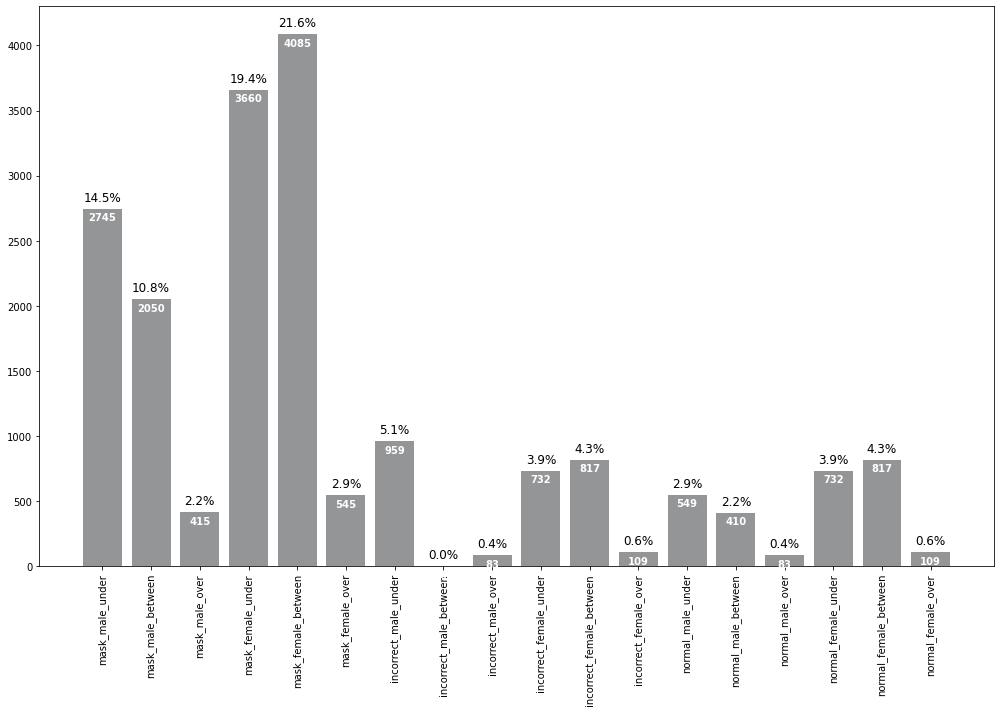

In [80]:
fig, ax_label = plt.subplots(1, 1, figsize=(14, 10))

x = list(range(0, 18))
total = np.sum(distribution) 
palette = sns.color_palette("pastel", as_cmap=True)

ax_label.bar(label, distribution, color = '#939597') 

for i, v in enumerate(distribution): 
    ax_label.text(i, v + 60,
                '%.1f%%' % (v / total * 100),
                horizontalalignment = 'center',
                size = 12,
                color='black')

for i, v in enumerate(distribution): 
    ax_label.text(i, v - 90, v,
                horizontalalignment = 'center',
                size = 10,
                color='w',
                fontweight='bold')

ymax = 4300
ax_label.set_ylim(0, ymax)

plt.xticks(range(0, 18), rotation = 90)
plt.tight_layout()
plt.show()


> 18개의 label 별 정보를 보면, 데이터가 없는 label도 있다는 것을 확인할 수 있다.

dataset을 분석한 결과 data imbalance 문제를 인지했다.
이러한 data imbalance 문제를 개선하기 위해 아래와 같은 방법이 제시되었다.

* GAN을 사용하여 dataset 증량
* cut mix를 적용하여 dataset 증량
* sampler를 적용하여 dataloader에서 자체적으로 imbalance 개선
* 부족한 data에 augmentation을 적용하여 dataset 증량
* label 분포가 균일한 validation set 제작
* label distribution analysis

---

## 2. 이미지 RGB 정보